Дан набор данных с 79 независимыми переменными, описывающими все аспекты жилых домов в Эймсе, штат Айова.
* **house_train.csv** - обучающий набор
* **house_test.csv** - набор тестов
* **data_description.txt** - полное описание каждого столбца, изначально подготовленное Дином Де Коком, но слегка отредактированное для соответствия именам столбцов, используемым здесь

Построить модель, делающую прогноз стоимости домов по заданным переменным.

#Step 1 - Preliminaries (Предварительные мероприятия)

In [ ]:
!pip install category_encoders

In [1]:
# Imports and Configuration
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from IPython.display import display
from pandas.api.types import CategoricalDtype
import pandas.util.testing as tm

from category_encoders import MEstimateEncoder
from category_encoders import CatBoostEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  


In [2]:
# read data
path_house_train = "/content/drive/MyDrive/Colab Notebooks/data/house_train.csv"
path_house_test = "/content/drive/MyDrive/Colab Notebooks/data/house_test.csv"

df_train = pd.read_csv(path_house_train)
df_test = pd.read_csv(path_house_test)

**Data Preprocessing**

Необходимо предварительно обработать данные, чтобы получить их в форме, подходящей для анализа.
Обработка будет состоять из:
* очистки данных, чтобы исправить любые ошибки или несоответствия
* кодирования статистических данных (числовой, категориальный)
* заполнения пропущенных значений.

In [3]:
'''Clean Data'''
# Некоторые категориальные особенности в этом наборе данных имеют очевидные опечатки в своих категориях:
df_train.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [ ]:
# Сравнение их со столбцами в data_description.txt показывает нам, что нужно переименовать.

In [5]:
def rename(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

In [6]:
'''Encode the Statistical Data Type'''

# Pandas имеет типы Python, соответствующие стандартным статистическим типам (числовые, категориальные и т. Д.). 
# Кодирование правильного типа предиктора помогает гарантировать, что каждый предиктор должным образом обрабатывается любыми функциями, которые мы используем, 
# и упрощает для нас последовательное применение преобразований.

# Числовые функции уже правильно закодированы (`float` для continuous, `int` для дискретных), но категориальные необходимо закодировать.
# читается как тип `int` (например MSSubClass - класс здания "20" -	1-STORY 1946 & NEWER ALL STYLES, "30" -	1-STORY 1945 & OLDER и т.д.), но на самом деле является категориальным.

# Номинативные (unordered) категориальные признаки
features_nom = ["MSSubClass", "MSZoning", "Street", "LandContour", "LotConfig", "Neighborhood", "Alley", "MiscFeature", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", 
                "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType",  "SaleType", "SaleCondition"]

# Перечислим возможные значения по каждому категориальному столбцу. Для обинаковых создадим five и ten_levels.

five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Добавим значение "None" для отсутствующих значений
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

In [7]:
'''Handle Missing Values (обработка отсутствующих значений)'''

# Обработка отсутствующих значений сделает feature engineering более гладкой. Присвоим 0 для пропущенных числовых значений и "None" для пропущенных категориальных значений. 

def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

In [8]:
'''treatment Data (обработка)'''

def treatment_data():

    # Read data
    path_house_train = "/content/drive/MyDrive/Colab Notebooks/data/house_train.csv"
    path_house_test = "/content/drive/MyDrive/Colab Notebooks/data/house_test.csv"
    df_train = pd.read_csv(path_house_train, index_col="Id")
    df_test = pd.read_csv(path_house_test, index_col="Id")

    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])

    # Preprocessing
    df = rename(df)
    df = encode(df)
    df = impute(df)

    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    
    return df_train, df_test

In [9]:
df_train, df_test = treatment_data()

In [10]:
df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,FirstFlrSF,SecondFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Threeseasonporch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,953.0,953.0,GasA,Ex,Y,SBrkr,953,694,0,1647,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2.0,460.0,TA,TA,Y,0,40,0,0,0,0,None,None,None,0,8,2007,WD,Normal,175000.0
1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790.0,Rec,163.0,589.0,1542.0,GasA,TA,Y,SBrkr,2073,0,0,2073,1.0,0.0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2.0,500.0,TA,TA,Y,349,0,0,0,0,0,None,MnPrv,None,0,2,2010,WD,Normal,210000.0
1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275.0,Unf,0.0,877.0,1152.0,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0.0,0.0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1.0,252.0,TA,TA,Y,0,60,0,0,0,

In [11]:
'''Establish Baseline (Определение базового уровня)'''

# Определим базовую оценку, по которой будем судить о нашей feature engineering.
# Функция, которая будет вычислять cross-validated RMSLE score для набора предикторов. Будем использовать для нашей модели XGBoost.

def score_dataset(X, y, model=XGBRegressor(objective = "reg:squarederror")):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [12]:
# Запустим функцию на обработанных данных без дополнительных предикторов и получим базовую оценку:

X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.12994 RMSLE


In [ ]:
# Эта базовая оценка попоможет узнать, действительно ли некоторый набор новых предикторов привел к каким-либо улучшениям или нет.

# Step 1.1 - Distribution validation and data normalization (проверка распределения и нормализация данных)

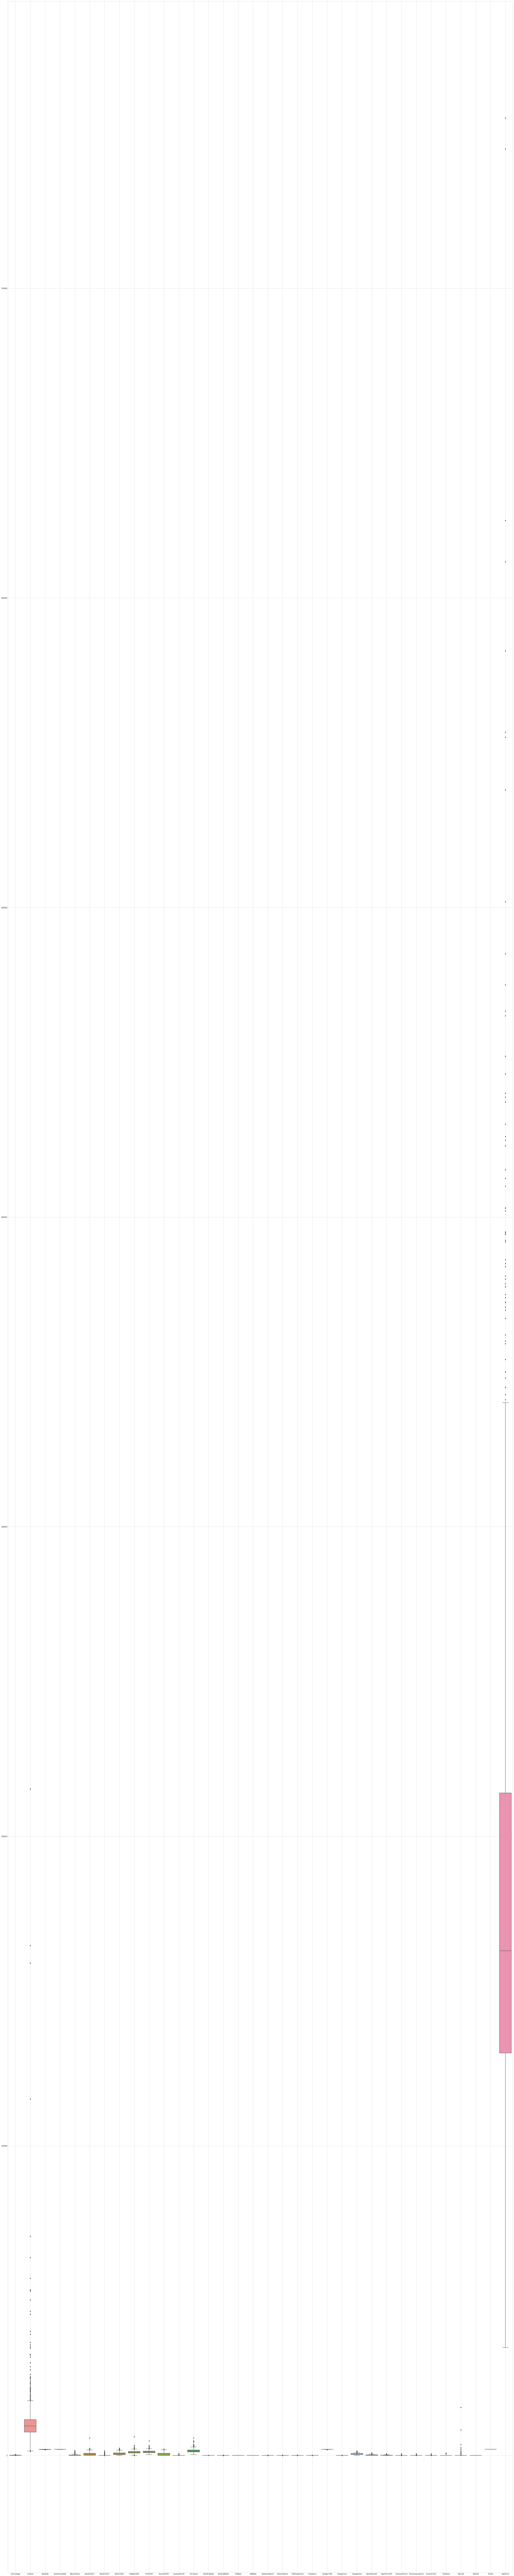

In [13]:
# поиск "выбросов" с помощью boxplot

plt.figure(figsize=(40,200))
sns.boxplot(data=df_train)
plt.grid(True)

In [ ]:
# столбцы с выбросами: 'LotFrontage','LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'FirstFlrSF','SecondFlrSF', 'GrLivArea','GarageArea', 'MiscVal', 'SalePrice'
# посмотреть их распределение

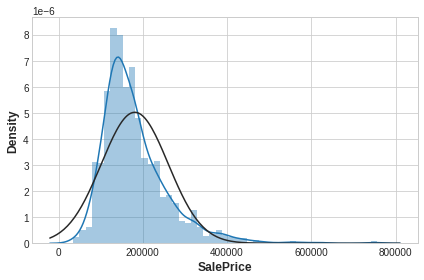

In [14]:
#histogram target

sns.distplot(df_train['SalePrice'], fit=norm)

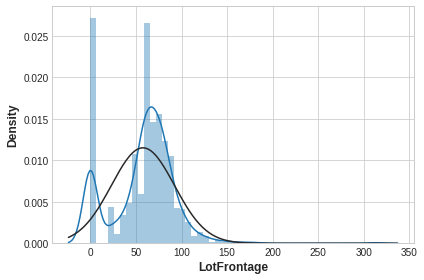

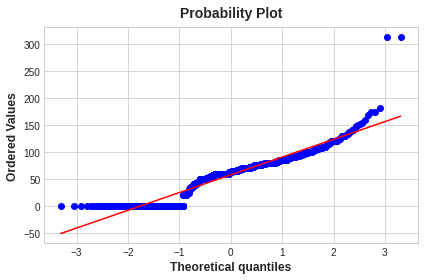

In [15]:
#histogram and normal probability plot
sns.distplot(df_train['LotFrontage'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['LotFrontage'], plot=plt)

In [16]:
# логарифмируем 'SalePrice', остальные нормализуем при помощи QuantileTransformer

# df_train['SalePrice'] = np.log(df_train['SalePrice'])

from sklearn.preprocessing import QuantileTransformer
# from sklearn.preprocessing import Normalizer
num_cols=['LotFrontage','LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'FirstFlrSF','SecondFlrSF', 'GrLivArea','GarageArea', 'MiscVal']
for i in num_cols:
  df_train[i] = QuantileTransformer(output_distribution='normal').fit_transform(df_train[[i]])
  # df[i] = Normalizer().fit_transform(df[[i]])
  # df[i]=(df[i]-df[i].mean())/df[i].std()

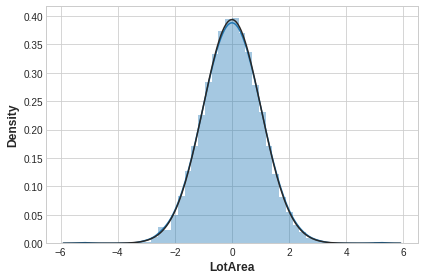

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.distplot(df_train['LotArea'], fit=norm);
fig = plt.figure()

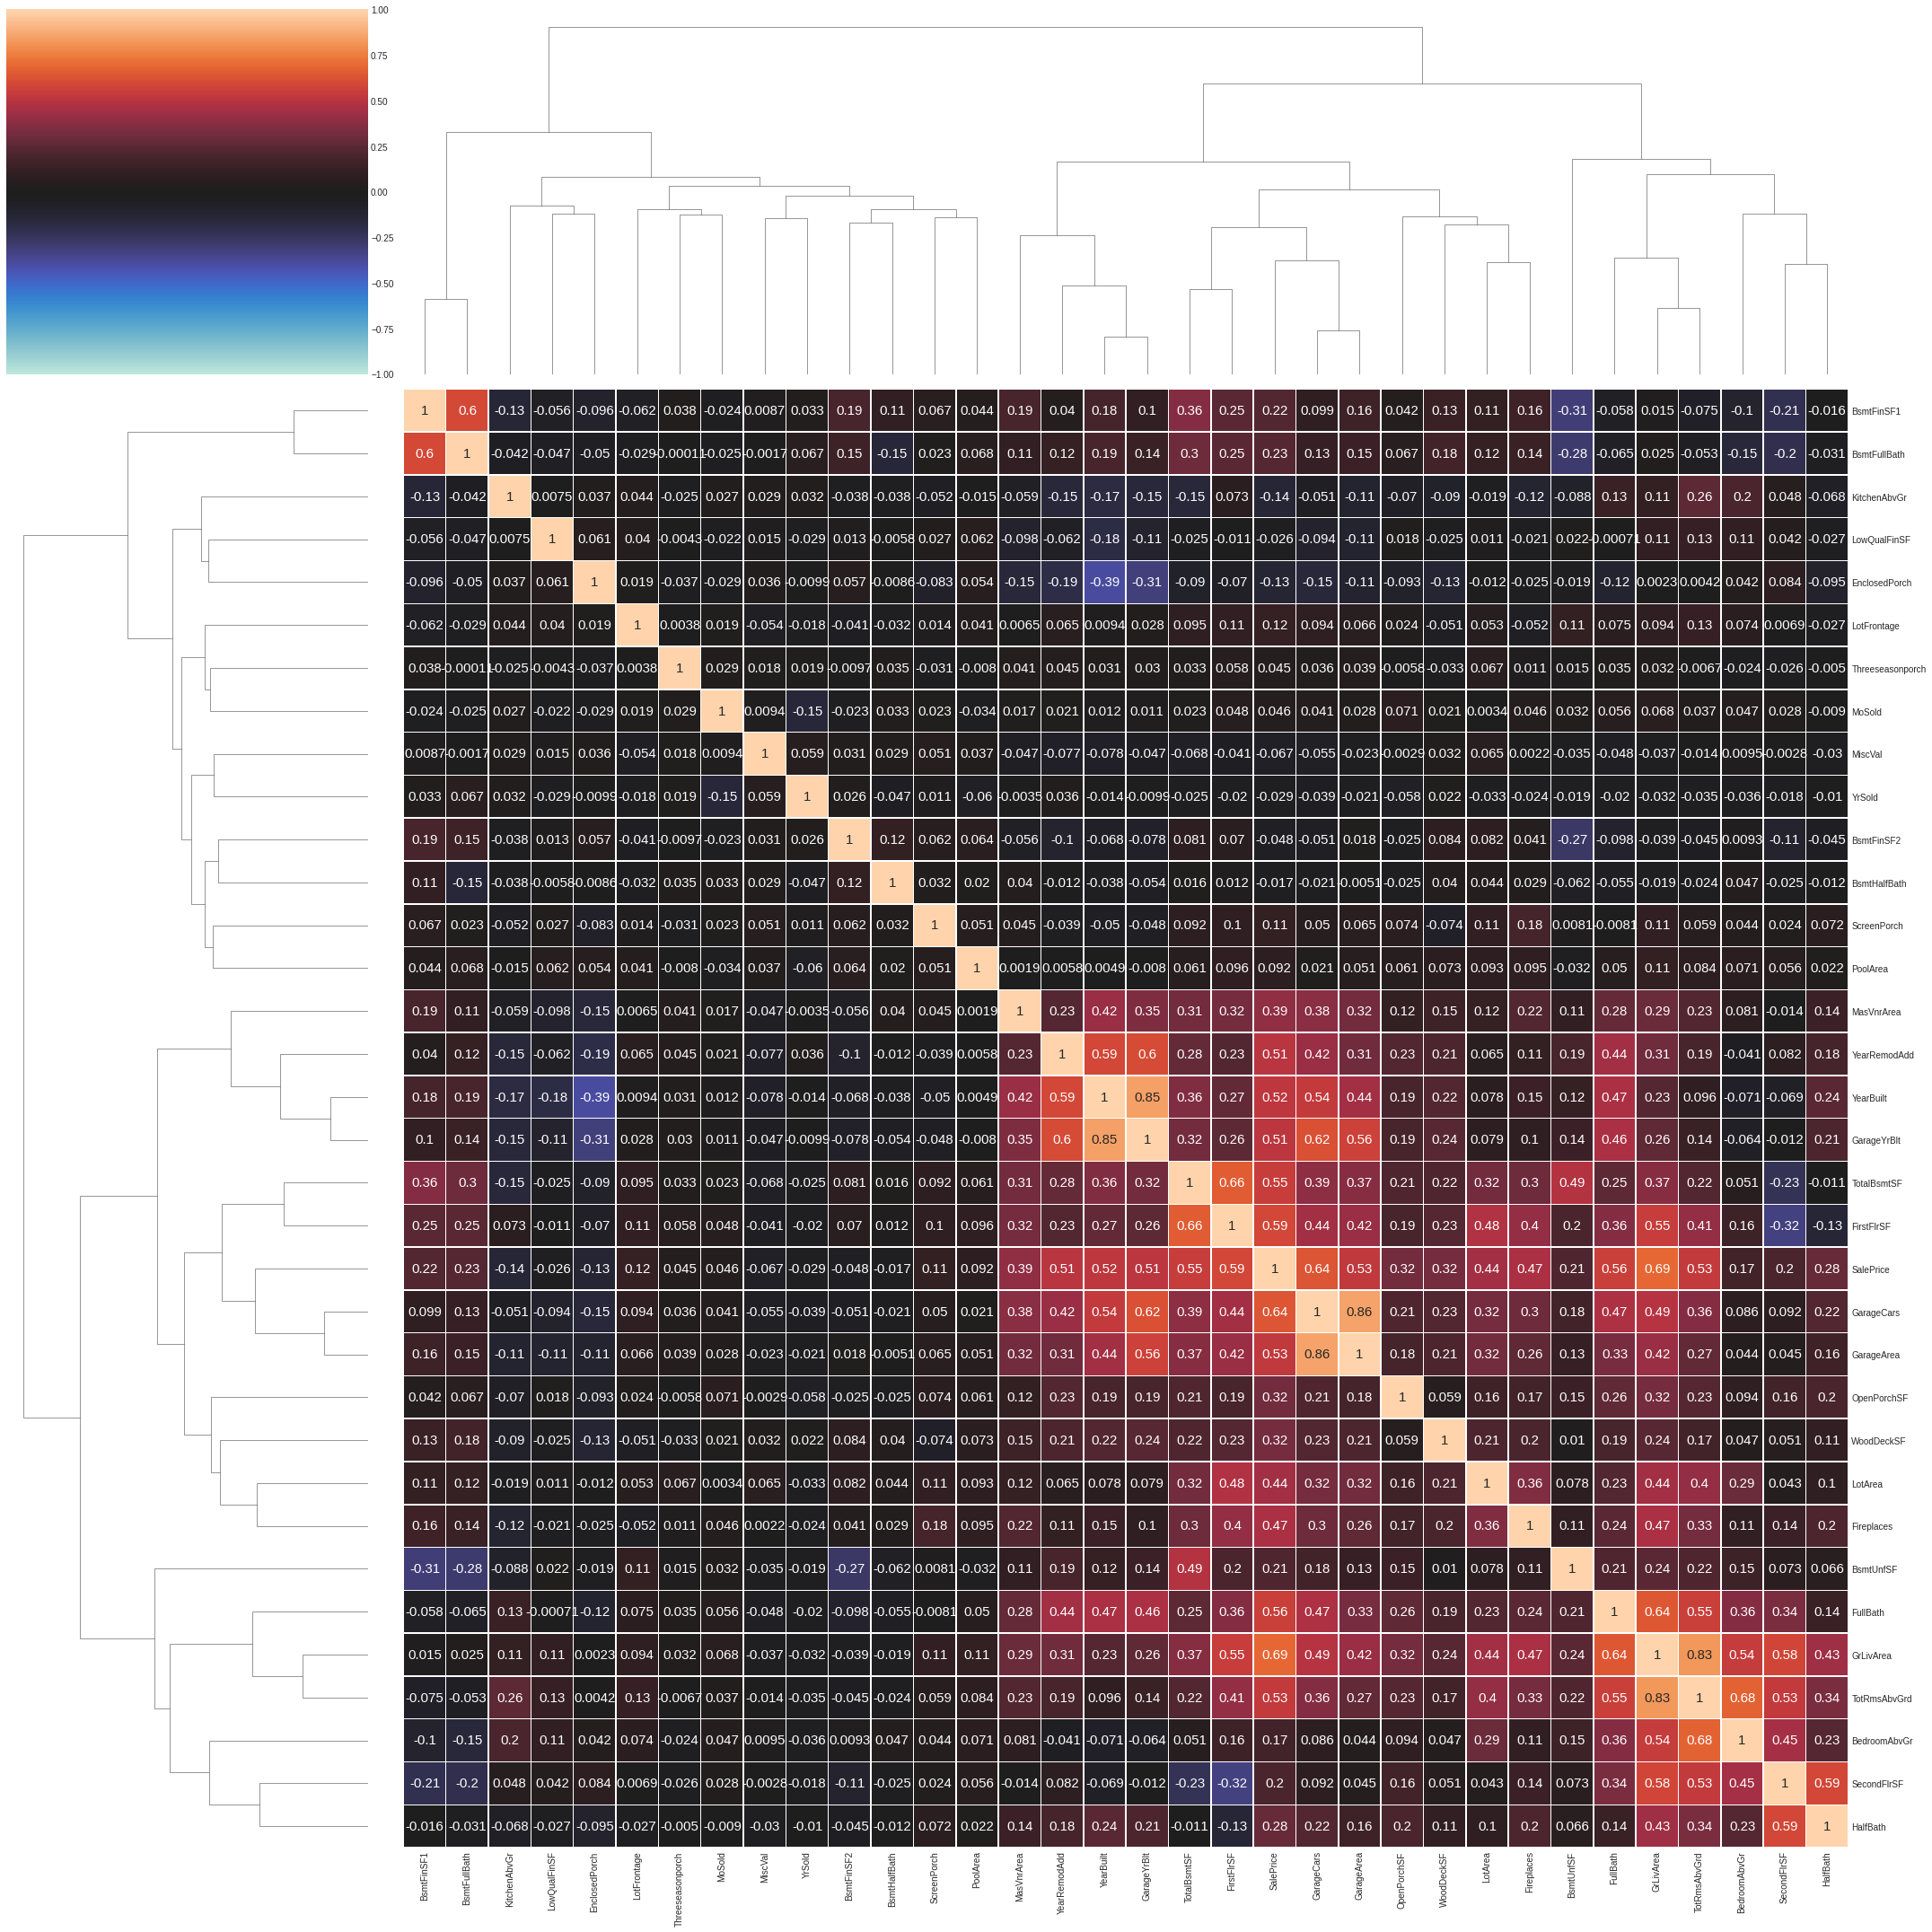

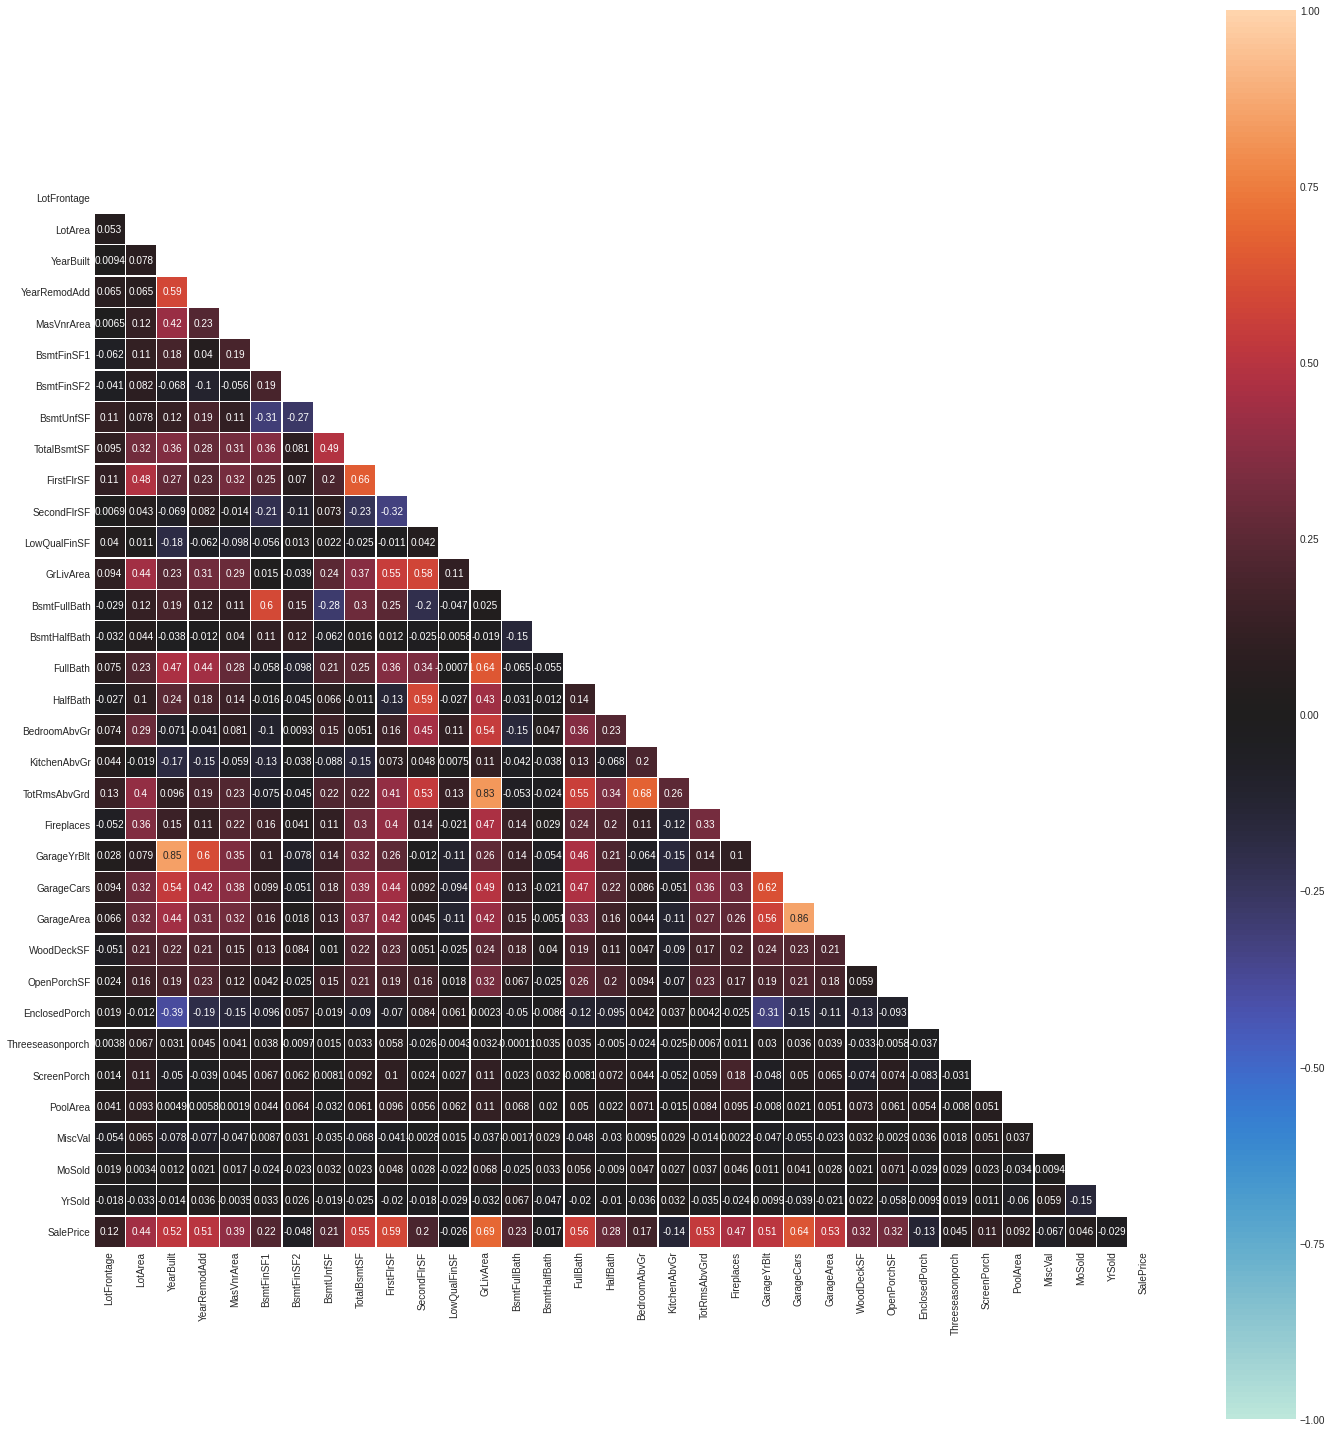

In [18]:
# Построим корреляционную матрицу для df_train

def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, linewidths=.5, annot=True, annot_kws={"size":15}, figsize=(30, 30))

# Треугольная матрица (с маской)
import matplotlib.pyplot as pl
matrix = np.triu(df_train.corr())
pl.figure(figsize=(20, 20))
sns.heatmap(df_train.corr(), vmin=-1.0, vmax=1.0, cmap="icefire", linewidths=.5, annot=True, annot_kws={"size":10}, square=True, mask=matrix)

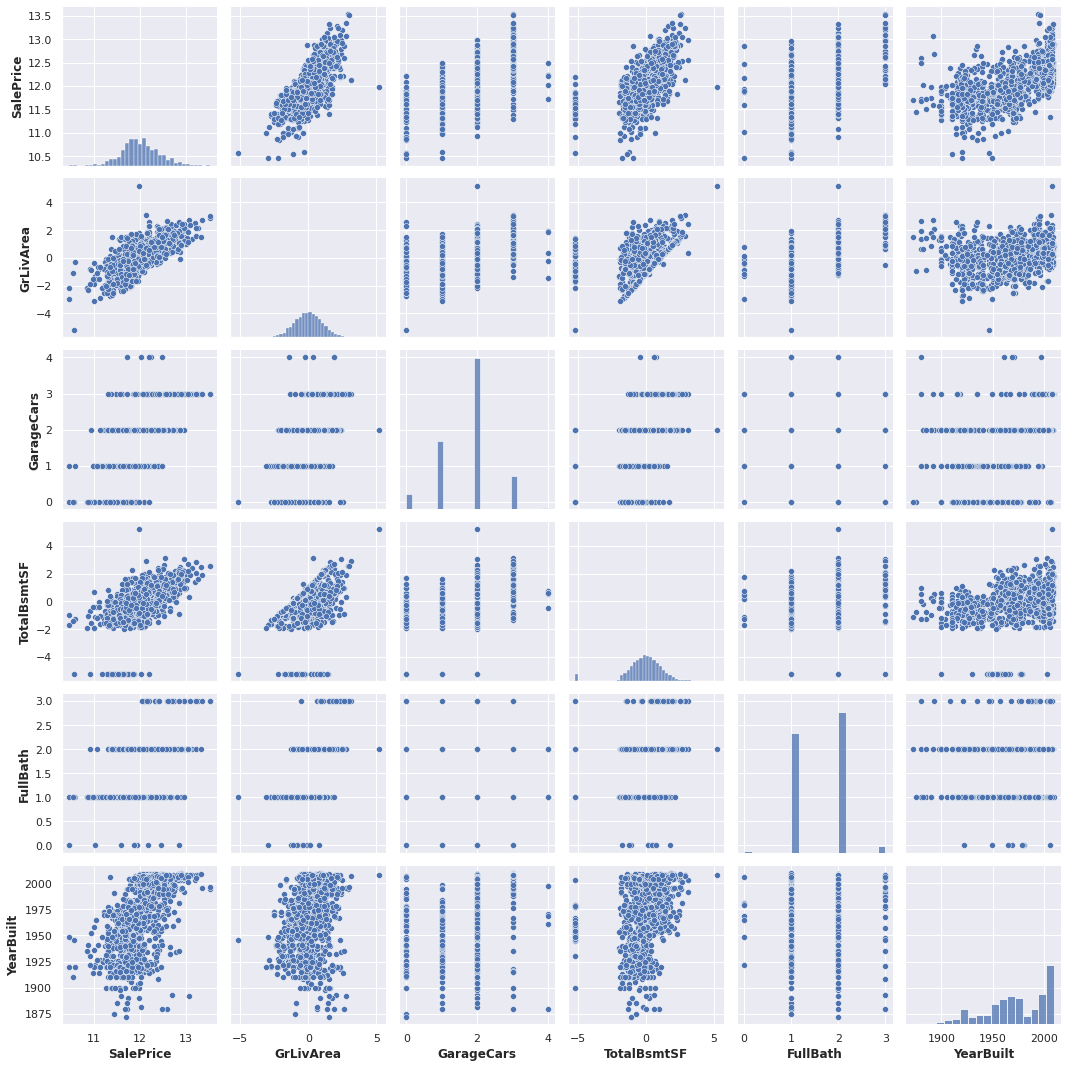

In [ ]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show()

#Step 2 - Feature Utility Scores (показатели полезности предикторов)

In [19]:
# Определим две используемые служебные функции, make_mi_scores и plot_mi_scores:

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [21]:
X = df_train.copy()
y = X.pop("SalePrice")

In [22]:
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,FirstFlrSF,SecondFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Threeseasonporch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,0.087933,-0.387078,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.807429,Gd,TA,PConc,Gd,TA,No,GLQ,0.667419,Unf,-5.199338,-0.927500,-0.455640,GasA,Ex,Y,SBrkr,-0.807936,0.981981,0,0.529301,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,0.475214,TA,TA,Y,0,61,0,0,0,0,None,None,None,-5.199338,2,2008,WD,Normal
2,20,RL,0.778225,0.062770,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,-5.199338,TA,TA,CBlock,Gd,TA,Gd,ALQ,1.109287,Unf,-5.199338,-0.507774,0.618059,GasA,Ex,Y,SBrkr,0.420385,-5.199338,0,-0.385776,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,-0.109365,TA,TA,Y,298,0,0,0,0,0,None,None,None,-5.199338,5,2007,WD,Normal
3,60,RL,0.189310,0.583496,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,0.667419,Gd,TA,PConc,Gd,TA,Mn,GLQ,0.170185,Unf,-5.199338,-0.085414,-0.203379,GasA,Ex,Y,SBrkr,-0.511976,1.027247,0,0.684763,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,0.798769,TA,TA,Y,0,42,0,0,0,0,None,None,None,-5.199338,9,2008,WD,Normal
4,70,RL,-0.165095,0.024235,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,-5.199338,TA,TA,BrkTil,TA,Gd,No,ALQ,-0.257495,Unf,-5.199338,0.114415,-0.832006,GasA,Gd,Y,SBrkr,-0.370902,0.751333,0,0.551076,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,0.916587,TA,TA,Y,0,35,272,0,0,0,None,None,None,-5.199338,2,2006,WD,Abnorml
5,60,RL,0.931971,1.265328,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,1.365257,Gd,TA,PConc,Gd,TA,Av,GLQ,0.524976,Unf,-5.199338,0.028859,0.392492,GasA,Ex,Y,SBrkr,0.169736,1.452321,0,1.317190,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,1.554270,TA,TA,Y,192,84,0,0,0,0,None,None,None,-5.199338,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,-0.020074,-0.567211,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,-5.199338,TA,TA,PConc,Gd,TA,No,Unf,-5.199338,Unf,-5.199338,0.941700,-0.098243,GasA,Ex,Y,SBrkr,-0.414267,0.586730,0,0.381675,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2.0,-0.109365,TA,TA,Y,0,40,0,0,0,0,None,None,None,-5.199338,8,2007,WD,Normal
1457,20,RL,0.999986,1.040242,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,0.531876,TA,TA,CBlock,Gd,TA,No,ALQ,0.830234,Rec,1.339665,0.208511,1.150024,GasA,TA,Y,SBrkr,2.056301,-5.199338,0,1.141972,1.0,0.0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2.0,0.168912,TA,TA,Y,349,0,0,0,0,0,None,MnPrv,None,-5.199338,2,2010,WD,Normal

In [23]:
mi_scores = make_mi_scores(X, y)
mi_scores

OverallQual     5.717084e-01
Neighborhood    5.242539e-01
GrLivArea       4.832132e-01
YearBuilt       4.083516e-01
TotalBsmtSF     3.705855e-01
                    ...     
PoolArea        2.220446e-16
MoSold          0.000000e+00
YrSold          0.000000e+00
PoolQC          0.000000e+00
MiscVal         0.000000e+00
Name: MI Scores, Length: 79, dtype: float64

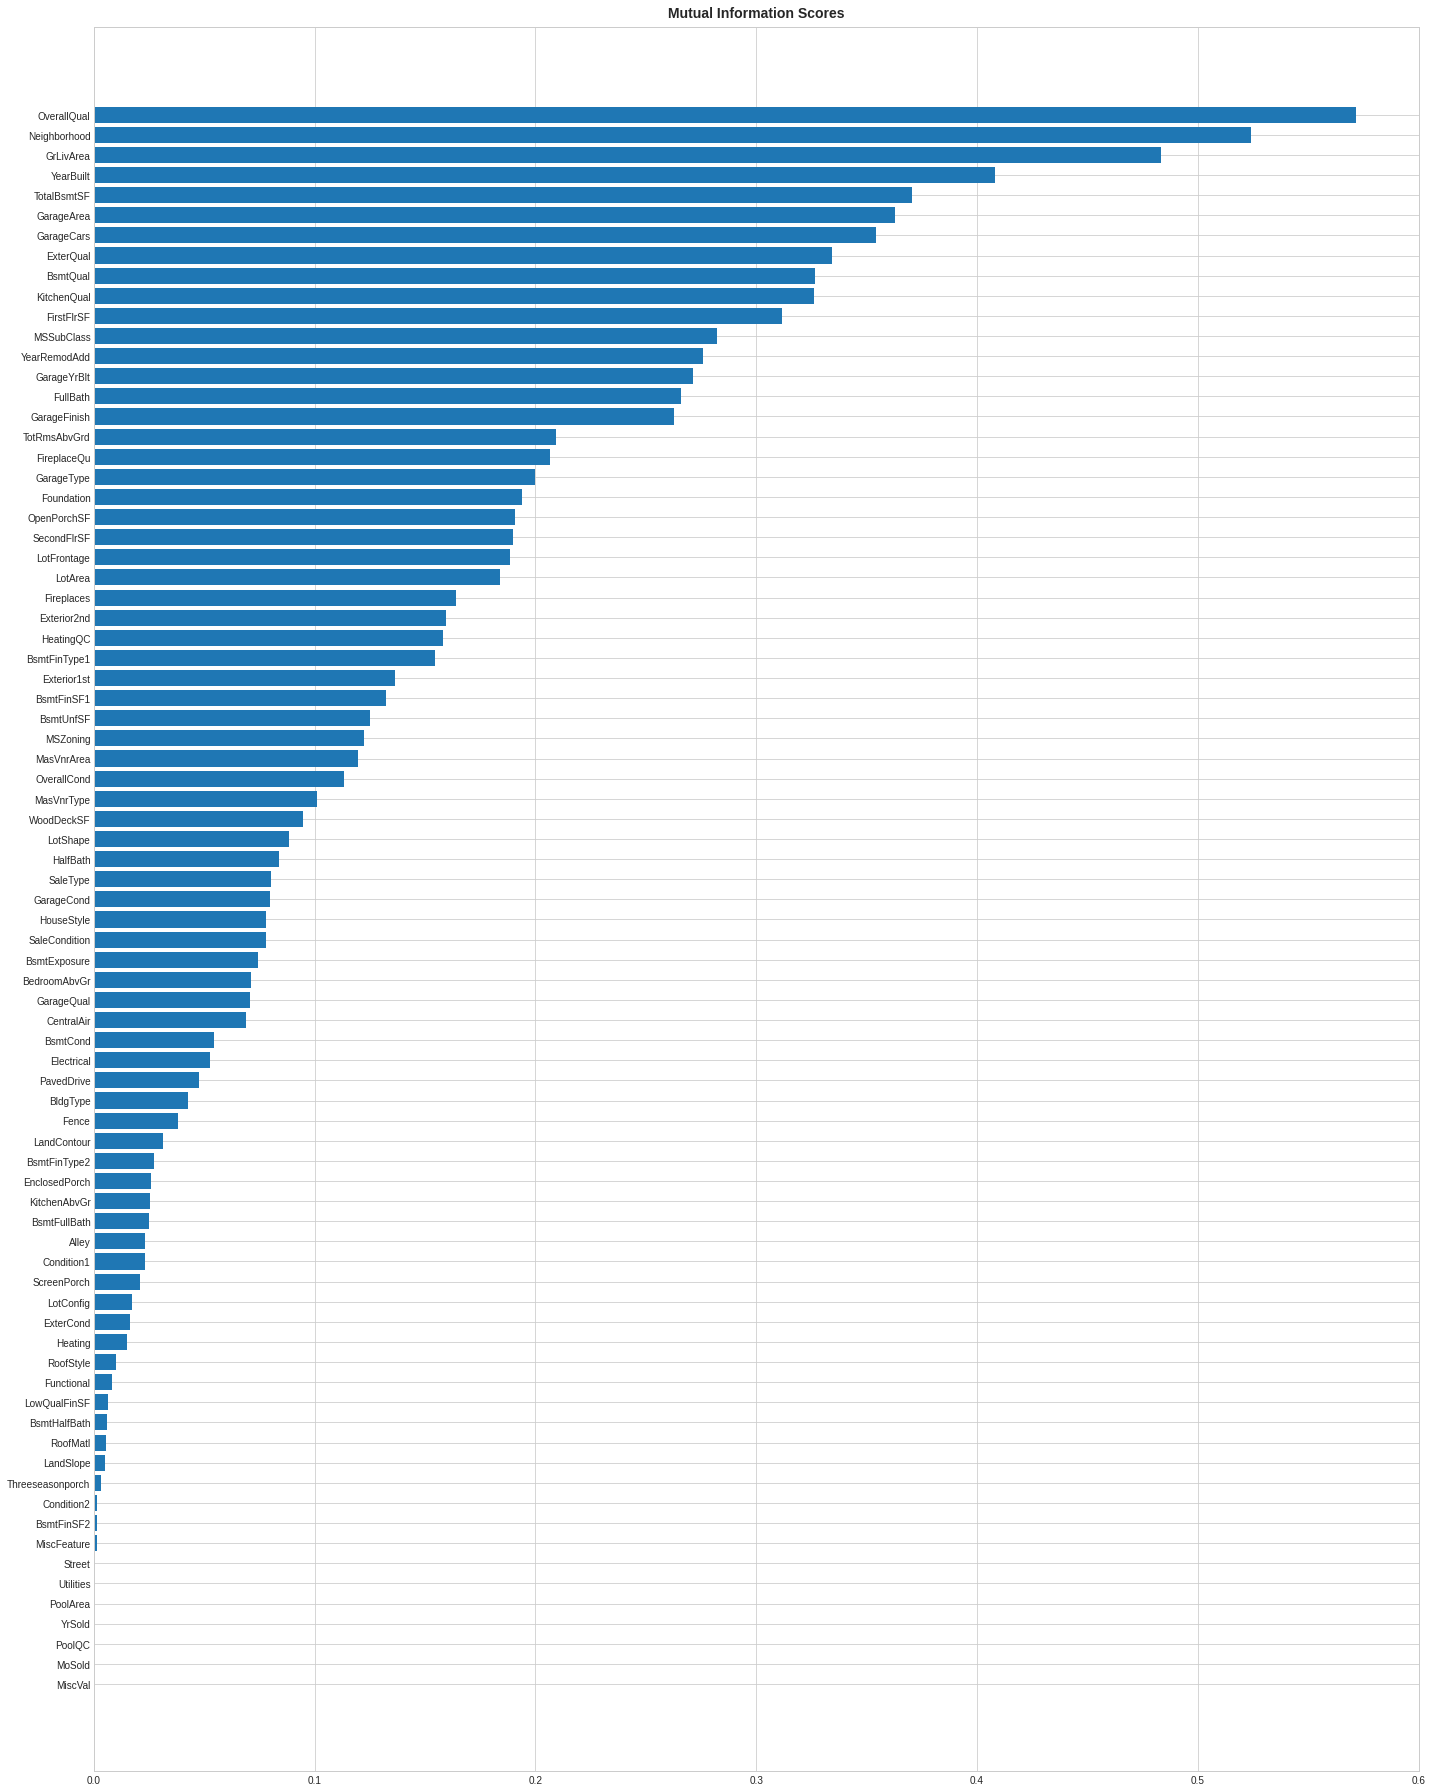

In [24]:
f, ax = plt.subplots(figsize=(20, 25))
plot_mi_scores(mi_scores)

In [ ]:
# У нас есть ряд предикторов, которые очень информативны, а также некоторые, которые не кажутся информативными вообще (по крайней мере, сами по себе). 
# Предикторы с наивысшими оценками обычно окупаются больше всего во время разработки предикторов.
# С другой стороны, обучение малоинформативным предикторами может привести к переобучению. 
# Отбросим предикторы с оценкой 0,0:

In [25]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [26]:
X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

score_dataset(X, y)

0.12954537723306828

#Step 3 - Create Features (создание новых предикторов)

Чтобы сделать процесс разработки предикторов более модульным, определим функцию, которая будет принимать подготовленный фрейм данных и передавать его через конвейер преобразований, чтобы получить окончательный набор предикторов.

In [27]:
# label encoding for the categorical features:

# Кодирование меток подходит для любого категориального предиктора, когда используется древовидный ансамбль, такой как XGBoost, даже для неупорядоченных категорий. 
# Если использовать модель линейной регрессии, необходимо использовать one-hot encoding, особенно для предикторов с неупорядоченными (unordered) категориями.

def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

In [28]:
'''Create Features with Pandas'''

# новые характеристики - LivLotRatio (коэф жилой площади) и Spaciousness (вместительность)
def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    return X

# interactions (взаимодействие категориальных и числовых характеристик) - разбивка типов жилья (BldgType) на отдельные столбцы (.get_dummies) и вывод по ним жилой площади (GrLivArea)
def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X

# interactions (взаимодействие категориальных и числовых характеристик) - разбивка типов высот подвалов (BsmtQual) на отдельные столбцы и вывод по ним их площади (TotalBsmtSF)
def interactions_2(df):
    X = pd.get_dummies(df.BsmtQual, prefix="Bsmt")
    X = X.mul(df.TotalBsmtSF, axis=0)
    return X

# счетчик количества параметров типа крыльца по каждому объекту (дому)
def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X

# групповая групировка - вывод средней (median) жилой площади (GrLivArea) по районам (Neighborhood)
# проверить стратегии median, mean и std
def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X

def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X


In [29]:
'''k-Means Clustering'''

# Можно использовать метки кластера как предикторы (столбец с 0, 1, 2, ...), либо можно использовать расстояние наблюдений до каждого кластера. 

cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [30]:
'''Principal Component Analysis'''

# Анализ главных компонентов - можно использовать для разложения вариационной структуры данных. 
# Алгоритм PCA дает нагрузки (loadings), которые описывают каждый компонент вариации, а также компоненты (components), которые были преобразованными точками данных. 
# Нагрузки могут предлагать предикторы для создания, компоненты можно напрямую использовать в качестве предикторов.

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [31]:
def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

In [32]:
'''Target Encoding'''

# 1.Разделим данные на вкладки, в каждой вкладке есть две части набора данных.
# 2.Обучим кодировщик на одном разбиении, но преобразуйем значения другого.
# 3.Повторим для всех разделений.
# Таким образом, обучение и преобразование всегда выполняются с независимыми наборами данных, как при использовании удерживающего набора, но без потери данных.

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Обучим кодировщик на одном разделении и преобразуем переменные на другом. 
    # Перебор разделений во всех вкладках дает полное преобразование. 
    # Теперь у нас есть по одному обученному кодировщику на каждой вкладке.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # Чтобы преобразовать тестовые данные, усредним кодировки, полученные из
    # каждой вкладки.

    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [ ]:
'''Create Final Feature Set'''

# Объединим все вместе. 

'''Помещение преобразований в отдельные функции упрощает эксперименты с различными комбинациями. 
Те, которые я оставил незакоментиными, дали наилучшие результаты.

In [ ]:
'''кодировщик CatBoostEncoder
параметр sigma = None (по умолч) добавляет шум нормального (гауссовского) распределения в обучающие данные, чтобы уменьшить переобучение (данные тестирования остаются нетронутыми). 
Сигма дает стандартное отклонение (разброс или «ширину») нормального распределения. Оптимальное значение обычно составляет от 0,05 до 0,6.'''

In [33]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))
    X = X.join(interactions_2(X))

      # Clustering
    X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    # PCA
    X = X.join(pca_inspired(X))
    # X = X.join(pca_components(X, pca_features))
    # X = X.join(indicate_outliers(X))

    X = label_encode(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)
    
    
     # Target Encoder
    '''MEstimateEncoder'''
    # encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    '''CatBoostEncoder''' 
    '''параметр sigma = None (по умолч) добавляет шум нормального (гауссовского) распределения в обучающие данные, чтобы уменьшить переобучение (данные тестирования остаются нетронутыми). 
        Сигма дает стандартное отклонение (разброс или «ширину») нормального распределения. Оптимальное значение обычно составляет от 0,05 до 0,6.'''
    encoder = CrossFoldEncoder(CatBoostEncoder, sigma = 0.1, a=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train)

0.1292497013139319

#Step 4 - Hyperparameter Tuning

настроить гиперпараметры с помощью XGBoost перед тем, как создавать окончательную отправку.

In [34]:
# настроим гиперпараметры с помощью XGBoost перед тем, как создавать окончательный результат (final submission).

X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

# из результатов автоматического тюнера гиперпараметров
# QuantileTransformer
#  Trial 14 finished with value: 0.1160043428408827 and parameters: {'max_depth': 4, 'learning_rate': 0.005493353659603202, 'n_estimators': 7052,
# 'min_child_weight': 1, 'colsample_bytree': 0.20205693345058393, 'subsample': 0.3561397235858007, 'reg_alpha': 0.02211825844621322,
#  'reg_lambda': 0.0326420216413062}. Best is trial 14 with value: 0.1160043428408827.

xgb_params = dict(
    max_depth=4,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.005493353659603202,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=7052,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.20205693345058393,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.3561397235858007,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.02211825844621322,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=0.0326420216413062,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
        verbosity = 0)     # cancel displaying warnings

xgb = XGBRegressor(**xgb_params)
score_dataset(X_train, y_train, xgb)

0.11592555085449956

Простая настройка параметров вручную может дать хорошие результаты. 
Но можено попробовать использовать один из автоматических тюнеров гиперпараметров scikit-learn, напр. Optuna

Вот как может быть использован Optuna с XGBoost:

In [ ]:
!pip install optuna

In [38]:
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
        verbosity = 0
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params

[I 2021-07-08 20:34:31,206] A new study created in memory with name: no-name-2f5026fa-64c6-4d0c-885d-de31e008991d
[I 2021-07-08 20:35:04,294] Trial 0 finished with value: 3.6416869536875636 and parameters: {'max_depth': 10, 'learning_rate': 0.00031134835740966445, 'n_estimators': 3984, 'min_child_weight': 3, 'colsample_bytree': 0.9330459034341356, 'subsample': 0.44722727673089147, 'reg_alpha': 3.6768164280947886, 'reg_lambda': 36.55029086345759}. Best is trial 0 with value: 3.6416869536875636.
[I 2021-07-08 20:36:59,666] Trial 1 finished with value: 5.695575465808948 and parameters: {'max_depth': 9, 'learning_rate': 0.00010492673808700076, 'n_estimators': 6725, 'min_child_weight': 4, 'colsample_bytree': 0.2483995423212716, 'subsample': 0.3105969395319833, 'reg_alpha': 0.00010990291270701459, 'reg_lambda': 0.0004584350480094809}. Best is trial 0 with value: 3.6416869536875636.
[I 2021-07-08 20:38:26,924] Trial 2 finished with value: 0.19452810259191958 and parameters: {'max_depth': 4, '

###Визуализация результатов Optuna.
Опционально, для информации.

[Optuna's visualizations](https://colab.research.google.com/drive/1sVUVXzrVB7lMQkZbK6cHrQ7nR0DH11QN#scrollTo=ciavOTxK6574&line=1&uniqifier=1)

In [39]:
import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [43]:
plot_param_importances(study)

In [44]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [40]:
plot_optimization_history(study)

In [41]:
plot_parallel_coordinate(study)

In [42]:
plot_slice(study)

#Step 5 - Train Model

In [46]:
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

xgb = XGBRegressor(**xgb_params, verbosity = 0)

# Преобразуем target y (kjufhbavbhetv), чтобы обучить и преобразовать прогноз

xgb.fit(X_train, np.log(y))
predictions = np.exp(xgb.predict(X_test))

Результат прогноза входит в топ 9% (1171/13876) результатов Kaggle chalange House Prices - Advanced Regression Techniques

